<a href="https://colab.research.google.com/github/vackup/CovidArgentina/blob/master/Covid_dataset_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import generales

In [1]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from google.colab import drive
import urllib.request
import json
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Global settings and functions

In [0]:
today = date.today()
days_name_weekends = ['Saturday','Sunday']
base_path = '/content/drive/My Drive/Colab Notebooks/'
path_google_dataset = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'

In [0]:
def get_df_without_weekends_and_holidays(df):
    df_without_weekends_and_holidays = df[~df.index.isin(df_feriados.index)]
    df_without_weekends_and_holidays = df_without_weekends_and_holidays[~df_without_weekends_and_holidays['Weekday Name'].isin(days_name_weekends)]

    return df_without_weekends_and_holidays

def get_df_only_weekends_and_holidays(df):
    df_only_holidays = df[df.index.isin(df_feriados.index)]
    df_only_weekends = df[df['Weekday Name'].isin(days_name_weekends)]

    df_contat = pd.concat([df_only_weekends, df_only_holidays])

    df_contat = df_contat.sort_index()

    return df_contat

def get_df_only_weekends(df):
    df_only_weekends = df[df['Weekday Name'].isin(days_name_weekends)]

    return df_only_weekends

# note: Apple can unexpectedly change version
def download_apple_report(directory="apple_reports"):
    '''Download Apple Mobility Trends report in CSV

        Args:
            directory: directory to which CSV report will be downloaded

        Returns:
            new_files (bool): flag indicating whether or not a new file has been downloaded
    '''
    version = "v3"
    json_link = "https://covid19-static.cdn-apple.com/covid19-mobility-data/current/" + version + "/index.json"
    with urllib.request.urlopen(json_link) as url:
           json_data = json.loads(url.read().decode())
    
    full_path = json_data['regions']['en-us']['csvPath']
    
    link = "https://covid19-static.cdn-apple.com" + json_data['basePath'] + full_path
    new_files = False

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    #file_name = "applemobilitytrends.csv"
    file_name = full_path.split('/')[-1] # last element

    if link[-3:] == "csv":
        path = os.path.join(directory, file_name)
        if not os.path.isfile(path):
            new_files = True
            urllib.request.urlretrieve(link, path)
            print(file_name)
        else:
            path_new = os.path.join(directory, file_name + "_new")
            urllib.request.urlretrieve(link, path_new)
            if os.path.getsize(path) == os.path.getsize(path_new):
                os.remove(path_new)
            else:
                new_files = True
                os.remove(path)
                os.rename(path_new, path)

    if not new_files:
        print('Apple: No updates')

    return new_files, file_name

# Dataset evolucion diaria infectados, muertos y recuperados

In [0]:
df = pd.read_json('https://pomber.github.io/covid19/timeseries.json')

In [0]:
df2 = pd.DataFrame(df['Argentina'].values.tolist())


In [0]:
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
df2 = df2.loc['2020-03-01' : today]

In [8]:
df2.shape


(102, 3)

In [9]:
df2.head(3)

,confirmed,deaths,recovered
date,,,
2020-03-01,0,0,0
2020-03-02,0,0,0
2020-03-03,1,0,0


In [10]:
df2.tail(3)

,confirmed,deaths,recovered
date,,,
2020-06-08,23620,693,7305
2020-06-09,24761,717,7568
2020-06-10,25987,735,7991


In [11]:
df2.dtypes

confirmed    int64
deaths       int64
recovered    int64
dtype: object

In [12]:
df2.index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
               '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08',
               '2020-06-09', '2020-06-10'],
              dtype='datetime64[ns]', name='date', length=102, freq=None)

In [0]:
df2['Weekday Name'] = df2.index.day_name()

In [14]:
# Display a random sampling of 5 rows
df2.sample(5, random_state=0)

,confirmed,deaths,recovered,Weekday Name
date,,,,
2020-03-27,589,13,72,Friday
2020-06-01,17415,556,5521,Monday
2020-03-03,1,0,0,Tuesday
2020-04-25,3780,185,1030,Saturday
2020-05-31,16851,539,5336,Sunday


In [0]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(25, 15)})

In [0]:
#cols_plot = ['confirmed', 'deaths', 'recovered']

#axes = df2[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
#for ax in axes:
#    ax.set_ylabel('Daily Totals')

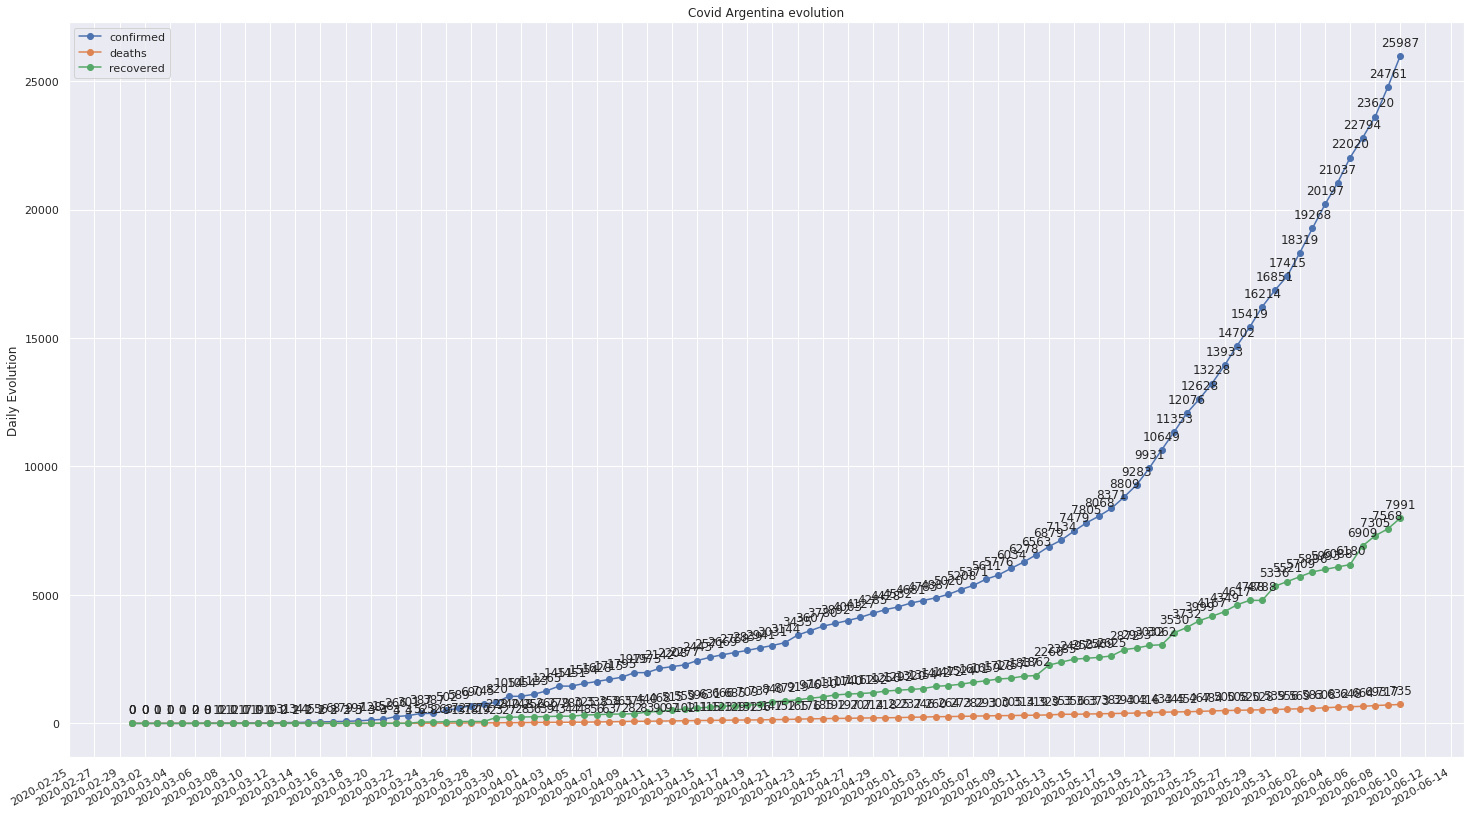

In [17]:
cols_plot = ['confirmed', 'deaths', 'recovered']

fig, ax = plt.subplots()

ax.plot(df2['confirmed'], marker='o', linestyle='-', label='confirmed')
ax.plot(df2['deaths'], marker='o', linestyle='-', label='deaths')
ax.plot(df2['recovered'], marker='o', linestyle='-', label='recovered')
#ax.plot(df2[cols_plot], marker='o', linestyle='-')

ax.set_ylabel('Daily Evolution')
ax.set_title('Covid Argentina evolution')

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

plt.legend(loc="upper left")
#plt.legend(cols_plot)

fig.autofmt_xdate()

for X, Y in zip(df2.index, df2['confirmed']):
    label = "{:.0f}".format(Y)

    ax.annotate(label, # this is the text
                 (X,Y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for X, Y in zip(df2.index, df2['deaths']):
    label = "{:.0f}".format(Y)

    ax.annotate(label, # this is the text
                 (X,Y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for X, Y in zip(df2.index, df2['recovered']):
    label = "{:.0f}".format(Y)

    ax.annotate(label, # this is the text
                 (X,Y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# Dataset feriados

In [0]:
path_feriados = base_path + 'feriados2020.csv'
df_feriados = pd.read_csv(path_feriados)

In [19]:
df_feriados.head()

,Fecha
0,2020-1-1
1,2020-2-24
2,2020-2-25
3,2020-3-23
4,2020-3-24


In [0]:
df_feriados.Fecha = pd.to_datetime(df_feriados.Fecha)

In [21]:
df_feriados.dtypes

Fecha    datetime64[ns]
dtype: object

In [0]:
df_feriados = df_feriados.set_index('Fecha')

In [23]:
df_feriados.index

DatetimeIndex(['2020-01-01', '2020-02-24', '2020-02-25', '2020-03-23',
               '2020-03-24', '2020-03-31', '2020-04-09', '2020-04-10',
               '2020-05-01', '2020-05-25', '2020-06-15', '2020-06-20',
               '2020-07-09', '2020-07-10', '2020-08-17', '2020-10-12',
               '2020-11-23', '2020-12-07', '2020-12-08', '2020-12-24',
               '2020-12-25', '2020-12-31'],
              dtype='datetime64[ns]', name='Fecha', freq=None)

# Dataset Apple mobility

In [24]:
new_files, apple_dataset_file_name = download_apple_report(base_path)

print(new_files, apple_dataset_file_name)

applemobilitytrends-2020-06-06.csv
True applemobilitytrends-2020-06-06.csv


In [0]:
path_apple_dataset = base_path + apple_dataset_file_name
df_apple = pd.read_csv(path_apple_dataset)

In [26]:
df_apple.head(5)

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,...,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06
0,country/region,Albania,driving,NaN,NaN,NaN,100.0,95.30,101.43,97.20,103.55,112.67,104.83,94.39,94.07,93.51,92.94,102.13,102.38,101.41,94.62,89.12,90.17,90.21,97.71,102.50,108.92,92.82,91.48,93.99,96.72,102.46,103.29,107.83,87.99,94.18,94.62,99.70,139.30,123.90,...,36.69,35.90,38.09,37.23,29.36,36.00,43.69,42.61,43.11,46.13,45.78,41.59,45.39,NaN,NaN,49.19,50.20,48.30,46.78,45.51,56.09,51.12,59.04,61.14,65.34,56.11,53.39,73.94,66.27,65.59,66.11,67.85,67.47,68.61,90.62,88.33,89.97,84.30,93.46,102.16
1,country/region,Albania,walking,NaN,NaN,NaN,100.0,100.68,98.93,98.46,100.85,100.13,82.13,95.65,97.78,95.39,94.24,93.73,97.06,77.27,83.37,82.73,84.39,88.19,90.79,88.70,79.32,87.12,88.06,99.40,85.84,94.63,99.74,81.41,90.19,90.45,94.16,95.69,109.21,108.40,...,37.53,41.49,38.25,38.68,32.28,43.41,49.59,46.44,52.84,52.37,48.10,44.86,68.87,NaN,NaN,61.79,56.46,54.41,48.36,45.20,67.46,63.20,66.57,67.97,68.49,48.02,42.56,74.97,70.66,65.67,67.16,69.89,56.67,59.53,84.18,93.86,87.72,94.75,83.24,81.96
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,118.45,124.01,95.44,95.13,95.42,97.66,99.42,113.34,118.23,91.31,93.37,91.12,92.35,96.74,111.24,123.96,89.01,91.66,89.18,94.49,95.98,111.12,121.53,89.23,96.42,96.97,101.68,104.90,122.91,127.62,...,27.12,32.22,34.45,22.69,28.23,16.44,32.01,33.63,35.13,35.56,40.25,33.82,19.82,NaN,NaN,38.87,41.01,44.34,38.29,22.01,40.01,41.34,41.53,41.52,47.52,41.34,23.81,28.11,40.86,42.91,43.77,48.26,40.39,23.77,39.64,41.88,43.77,45.84,52.26,47.48
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,116.72,114.14,84.54,101.37,106.12,104.91,102.56,104.88,98.83,73.64,94.27,93.86,92.20,96.00,98.99,97.42,67.21,95.18,96.25,100.39,99.10,105.00,106.45,73.12,104.20,105.87,111.47,113.20,128.75,103.47,...,17.49,22.78,24.80,16.62,20.61,12.44,21.35,22.63,23.84,23.84,30.63,24.84,15.58,NaN,NaN,28.33,28.44,31.63,28.81,18.49,30.79,30.37,28.85,29.04,31.99,31.40,16.83,21.37,30.85,33.27,32.63,34.67,28.70,17.40,29.50,31.25,30.65,31.93,37.34,33.53
4,country/region,Australia,driving,AU,NaN,NaN,100.0,102.98,104.21,108.63,109.08,89.00,99.35,103.53,106.80,107.40,115.65,109.66,88.59,85.18,95.91,99.40,99.92,103.04,103.73,85.73,93.39,95.83,98.63,102.40,107.46,106.55,86.33,98.78,100.08,103.28,106.19,116.62,115.36,93.51,...,59.46,59.46,63.12,58.40,48.67,58.18,62.51,64.04,66.19,71.34,67.64,50.96,63.56,NaN,NaN,71.12,77.24,79.75,65.88,72.17,73.58,75.83,76.35,81.42,82.51,65.78,74.12,77.10,79.92,82.65,88.37,92.70,73.04,78.07,80.87,84.72,88.62,100.24,104.34,83.85


In [0]:
df_apple_argentina = df_apple[df_apple.region.eq("Argentina")]

In [28]:
df_apple_argentina.head()

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,...,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,118.45,124.01,95.44,95.13,95.42,97.66,99.42,113.34,118.23,91.31,93.37,91.12,92.35,96.74,111.24,123.96,89.01,91.66,89.18,94.49,95.98,111.12,121.53,89.23,96.42,96.97,101.68,104.9,122.91,127.62,...,27.12,32.22,34.45,22.69,28.23,16.44,32.01,33.63,35.13,35.56,40.25,33.82,19.82,NaN,NaN,38.87,41.01,44.34,38.29,22.01,40.01,41.34,41.53,41.52,47.52,41.34,23.81,28.11,40.86,42.91,43.77,48.26,40.39,23.77,39.64,41.88,43.77,45.84,52.26,47.48
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,116.72,114.14,84.54,101.37,106.12,104.91,102.56,104.88,98.83,73.64,94.27,93.86,92.20,96.00,98.99,97.42,67.21,95.18,96.25,100.39,99.10,105.00,106.45,73.12,104.20,105.87,111.47,113.2,128.75,103.47,...,17.49,22.78,24.80,16.62,20.61,12.44,21.35,22.63,23.84,23.84,30.63,24.84,15.58,NaN,NaN,28.33,28.44,31.63,28.81,18.49,30.79,30.37,28.85,29.04,31.99,31.40,16.83,21.37,30.85,33.27,32.63,34.67,28.70,17.40,29.50,31.25,30.65,31.93,37.34,33.53


In [29]:
df_apple_argentina.drop(columns=['geo_type', 'region', 'alternative_name', 'sub-region', 'country'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
df_apple_argentina.head()

,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,...,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06
2,driving,100.0,97.07,102.45,111.21,118.45,124.01,95.44,95.13,95.42,97.66,99.42,113.34,118.23,91.31,93.37,91.12,92.35,96.74,111.24,123.96,89.01,91.66,89.18,94.49,95.98,111.12,121.53,89.23,96.42,96.97,101.68,104.9,122.91,127.62,88.20,92.28,98.15,98.96,104.71,...,27.12,32.22,34.45,22.69,28.23,16.44,32.01,33.63,35.13,35.56,40.25,33.82,19.82,NaN,NaN,38.87,41.01,44.34,38.29,22.01,40.01,41.34,41.53,41.52,47.52,41.34,23.81,28.11,40.86,42.91,43.77,48.26,40.39,23.77,39.64,41.88,43.77,45.84,52.26,47.48
3,walking,100.0,95.11,101.37,112.67,116.72,114.14,84.54,101.37,106.12,104.91,102.56,104.88,98.83,73.64,94.27,93.86,92.20,96.00,98.99,97.42,67.21,95.18,96.25,100.39,99.10,105.00,106.45,73.12,104.20,105.87,111.47,113.2,128.75,103.47,69.12,93.42,111.49,107.02,111.36,...,17.49,22.78,24.80,16.62,20.61,12.44,21.35,22.63,23.84,23.84,30.63,24.84,15.58,NaN,NaN,28.33,28.44,31.63,28.81,18.49,30.79,30.37,28.85,29.04,31.99,31.40,16.83,21.37,30.85,33.27,32.63,34.67,28.70,17.40,29.50,31.25,30.65,31.93,37.34,33.53


In [0]:
df_apple_argentina = df_apple_argentina.set_index('transportation_type')

In [0]:
df_apple_argentina_t = df_apple_argentina.transpose()

In [33]:
df_apple_argentina_t

transportation_type,driving,walking
2020-01-13,100.00,100.00
2020-01-14,97.07,95.11
2020-01-15,102.45,101.37
2020-01-16,111.21,112.67
2020-01-17,118.45,116.72
...,...,...
2020-06-02,41.88,31.25
2020-06-03,43.77,30.65
2020-06-04,45.84,31.93
2020-06-05,52.26,37.34


In [0]:
# Converting the index as date
df_apple_argentina_t.index = pd.to_datetime(df_apple_argentina_t.index)

In [35]:
type(df_apple_argentina_t.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [36]:
df_apple_argentina_t.head()

transportation_type,driving,walking
2020-01-13,100.00,100.00
2020-01-14,97.07,95.11
2020-01-15,102.45,101.37
2020-01-16,111.21,112.67
2020-01-17,118.45,116.72


In [0]:
df_apple_argentina_t.index.rename('date', inplace=True)

In [38]:
df_apple_argentina_t.head()

transportation_type,driving,walking
date,,
2020-01-13,100.00,100.00
2020-01-14,97.07,95.11
2020-01-15,102.45,101.37
2020-01-16,111.21,112.67
2020-01-17,118.45,116.72


In [0]:
df_apple_argentina_t = df_apple_argentina_t.loc['2020-03-01' : today]

In [40]:
df_apple_argentina_t.head(10)

transportation_type,driving,walking
date,,
2020-03-01,81.13,68.50
2020-03-02,86.76,101.01
2020-03-03,88.90,104.39
2020-03-04,92.74,108.23
2020-03-05,97.45,113.92
2020-03-06,118.32,126.70
2020-03-07,122.78,112.81
2020-03-08,80.36,70.94
2020-03-09,89.28,109.38


In [41]:
df_apple_argentina_t['driving-100'] = df_apple_argentina_t['driving'] - 100
df_apple_argentina_t['walking-100'] = df_apple_argentina_t['walking'] - 100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
df_apple_argentina_t.head()

transportation_type,driving,walking,driving-100,walking-100
date,,,,
2020-03-01,81.13,68.50,-18.87,-31.50
2020-03-02,86.76,101.01,-13.24,1.01
2020-03-03,88.90,104.39,-11.10,4.39
2020-03-04,92.74,108.23,-7.26,8.23
2020-03-05,97.45,113.92,-2.55,13.92


In [43]:
df_apple_argentina_t['Weekday Name'] = df_apple_argentina_t.index.day_name()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
df_apple_argentina_t.head(10)

transportation_type,driving,walking,driving-100,walking-100,Weekday Name
date,,,,,
2020-03-01,81.13,68.50,-18.87,-31.50,Sunday
2020-03-02,86.76,101.01,-13.24,1.01,Monday
2020-03-03,88.90,104.39,-11.10,4.39,Tuesday
2020-03-04,92.74,108.23,-7.26,8.23,Wednesday
2020-03-05,97.45,113.92,-2.55,13.92,Thursday
2020-03-06,118.32,126.70,18.32,26.70,Friday
2020-03-07,122.78,112.81,22.78,12.81,Saturday
2020-03-08,80.36,70.94,-19.64,-29.06,Sunday
2020-03-09,89.28,109.38,-10.72,9.38,Monday


In [0]:
df_apple_without_weekends_and_holidays = get_df_without_weekends_and_holidays(df_apple_argentina_t)

In [46]:
df_apple_without_weekends_and_holidays.head(10)

transportation_type,driving,walking,driving-100,walking-100,Weekday Name
date,,,,,
2020-03-02,86.76,101.01,-13.24,1.01,Monday
2020-03-03,88.90,104.39,-11.10,4.39,Tuesday
2020-03-04,92.74,108.23,-7.26,8.23,Wednesday
2020-03-05,97.45,113.92,-2.55,13.92,Thursday
2020-03-06,118.32,126.70,18.32,26.70,Friday
2020-03-09,89.28,109.38,-10.72,9.38,Monday
2020-03-10,89.29,109.62,-10.71,9.62,Tuesday
2020-03-11,82.73,83.06,-17.27,-16.94,Wednesday
2020-03-12,86.67,106.85,-13.33,6.85,Thursday


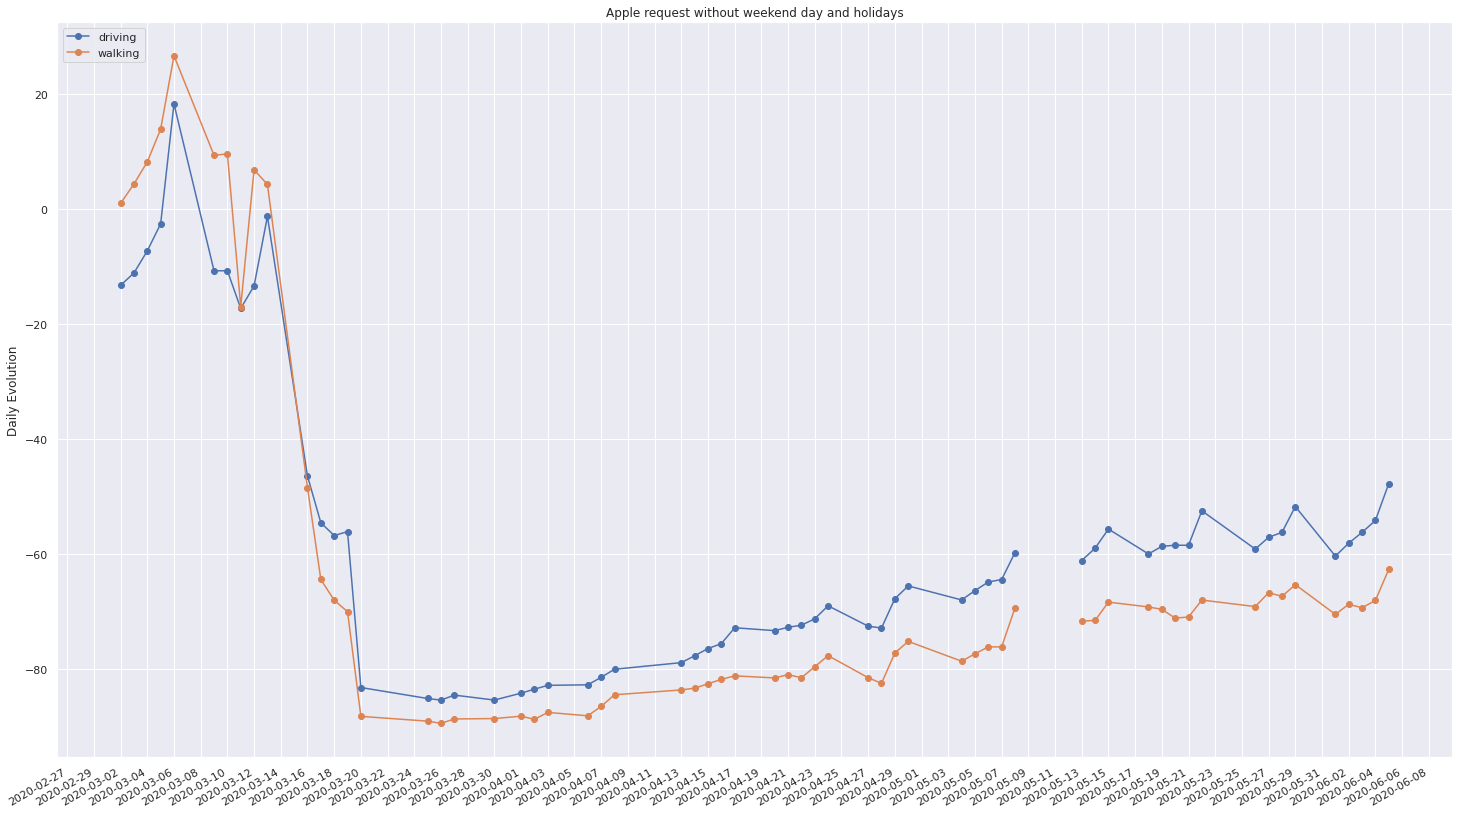

In [47]:
fig, ax = plt.subplots()

ax.plot(df_apple_without_weekends_and_holidays['driving-100'], marker='o', linestyle='-', label='driving')
ax.plot(df_apple_without_weekends_and_holidays['walking-100'], marker='o', linestyle='-', label='walking')

ax.set_ylabel('Daily Evolution')
ax.set_title('Apple request without weekend day and holidays')

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

plt.legend(loc="upper left")

fig.autofmt_xdate()

# Dataset Google Mobility

In [48]:
df_google = pd.read_csv(path_google_dataset)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
df_google.head(10)

,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0
5,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-20,-2.0,1.0,6.0,1.0,1.0,1.0
6,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-21,-3.0,2.0,6.0,0.0,-1.0,1.0
7,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-22,-2.0,2.0,4.0,-2.0,3.0,1.0
8,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-23,-1.0,3.0,3.0,-1.0,4.0,1.0
9,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-24,-3.0,0.0,5.0,-1.0,3.0,1.0


In [0]:
df_google = df_google[df_google.country_region.eq('Argentina')]

In [51]:
df_google

,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
2036,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-15,1.0,-3.0,-3.0,4.0,-1.0,0.0
2037,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-16,-6.0,-6.0,-14.0,-2.0,-4.0,2.0
2038,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-17,-10.0,-8.0,-23.0,-2.0,7.0,1.0
2039,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-18,3.0,3.0,-2.0,9.0,9.0,-1.0
2040,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-19,1.0,0.0,10.0,8.0,11.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4881,AR,Argentina,Tucumán,NaN,AR-T,NaN,2020-06-03,-55.0,-5.0,-63.0,-54.0,-10.0,11.0
4882,AR,Argentina,Tucumán,NaN,AR-T,NaN,2020-06-04,-59.0,-12.0,-71.0,-60.0,-13.0,13.0
4883,AR,Argentina,Tucumán,NaN,AR-T,NaN,2020-06-05,-52.0,3.0,-60.0,-58.0,-8.0,12.0
4884,AR,Argentina,Tucumán,NaN,AR-T,NaN,2020-06-06,-53.0,6.0,-66.0,-63.0,0.0,11.0


In [0]:
df_google = df_google[~df_google.sub_region_1.notnull()]

In [53]:
df_google

,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
2036,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-15,1.0,-3.0,-3.0,4.0,-1.0,0.0
2037,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-16,-6.0,-6.0,-14.0,-2.0,-4.0,2.0
2038,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-17,-10.0,-8.0,-23.0,-2.0,7.0,1.0
2039,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-18,3.0,3.0,-2.0,9.0,9.0,-1.0
2040,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-19,1.0,0.0,10.0,8.0,11.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,AR,Argentina,NaN,NaN,NaN,NaN,2020-06-03,-67.0,-21.0,-85.0,-53.0,-28.0,17.0
2146,AR,Argentina,NaN,NaN,NaN,NaN,2020-06-04,-67.0,-21.0,-86.0,-53.0,-29.0,18.0
2147,AR,Argentina,NaN,NaN,NaN,NaN,2020-06-05,-65.0,-16.0,-85.0,-52.0,-28.0,20.0
2148,AR,Argentina,NaN,NaN,NaN,NaN,2020-06-06,-66.0,-12.0,-86.0,-50.0,-19.0,18.0


In [54]:
df_google.drop(columns=['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [55]:
df_google.head()

,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
2036,NaN,NaN,2020-02-15,1.0,-3.0,-3.0,4.0,-1.0,0.0
2037,NaN,NaN,2020-02-16,-6.0,-6.0,-14.0,-2.0,-4.0,2.0
2038,NaN,NaN,2020-02-17,-10.0,-8.0,-23.0,-2.0,7.0,1.0
2039,NaN,NaN,2020-02-18,3.0,3.0,-2.0,9.0,9.0,-1.0
2040,NaN,NaN,2020-02-19,1.0,0.0,10.0,8.0,11.0,-2.0


In [56]:
df_google.dtypes

iso_3166_2_code                                        object
census_fips_code                                      float64
date                                                   object
retail_and_recreation_percent_change_from_baseline    float64
grocery_and_pharmacy_percent_change_from_baseline     float64
parks_percent_change_from_baseline                    float64
transit_stations_percent_change_from_baseline         float64
workplaces_percent_change_from_baseline               float64
residential_percent_change_from_baseline              float64
dtype: object

In [57]:
df_google.date = pd.to_datetime(df_google.date)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [58]:
df_google.dtypes

iso_3166_2_code                                               object
census_fips_code                                             float64
date                                                  datetime64[ns]
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
dtype: object

In [0]:
df_google = df_google.set_index('date')

In [60]:
df_google.index

DatetimeIndex(['2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24',
               ...
               '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-06', '2020-06-07'],
              dtype='datetime64[ns]', name='date', length=114, freq=None)

In [61]:
df_google = df_google.loc['2020-03-01' : today]
df_google.head(10)

,iso_3166_2_code,census_fips_code,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,
2020-03-01,NaN,NaN,-3.0,3.0,-11.0,1.0,-2.0,2.0
2020-03-02,NaN,NaN,1.0,4.0,-8.0,7.0,16.0,-1.0
2020-03-03,NaN,NaN,0.0,5.0,-6.0,8.0,16.0,-1.0
2020-03-04,NaN,NaN,-1.0,3.0,-1.0,8.0,18.0,-2.0
2020-03-05,NaN,NaN,1.0,4.0,-9.0,10.0,18.0,-1.0
2020-03-06,NaN,NaN,6.0,8.0,-7.0,12.0,18.0,-2.0
2020-03-07,NaN,NaN,5.0,7.0,-10.0,8.0,3.0,1.0
2020-03-08,NaN,NaN,3.0,4.0,-12.0,3.0,-2.0,2.0
2020-03-09,NaN,NaN,1.0,5.0,-9.0,13.0,15.0,-1.0


In [0]:
df_google['Weekday Name'] = df_google.index.day_name()

In [0]:
df_google_without_weekends_and_holidays = get_df_without_weekends_and_holidays(df_google)

In [64]:
df_google_without_weekends_and_holidays.head(100)

,iso_3166_2_code,census_fips_code,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Weekday Name
date,,,,,,,,,
2020-03-02,NaN,NaN,1.0,4.0,-8.0,7.0,16.0,-1.0,Monday
2020-03-03,NaN,NaN,0.0,5.0,-6.0,8.0,16.0,-1.0,Tuesday
2020-03-04,NaN,NaN,-1.0,3.0,-1.0,8.0,18.0,-2.0,Wednesday
2020-03-05,NaN,NaN,1.0,4.0,-9.0,10.0,18.0,-1.0,Thursday
2020-03-06,NaN,NaN,6.0,8.0,-7.0,12.0,18.0,-2.0,Friday
...,...,...,...,...,...,...,...,...,...
2020-06-01,NaN,NaN,-67.0,-24.0,-87.0,-54.0,-29.0,18.0,Monday
2020-06-02,NaN,NaN,-66.0,-20.0,-85.0,-52.0,-29.0,17.0,Tuesday
2020-06-03,NaN,NaN,-67.0,-21.0,-85.0,-53.0,-28.0,17.0,Wednesday


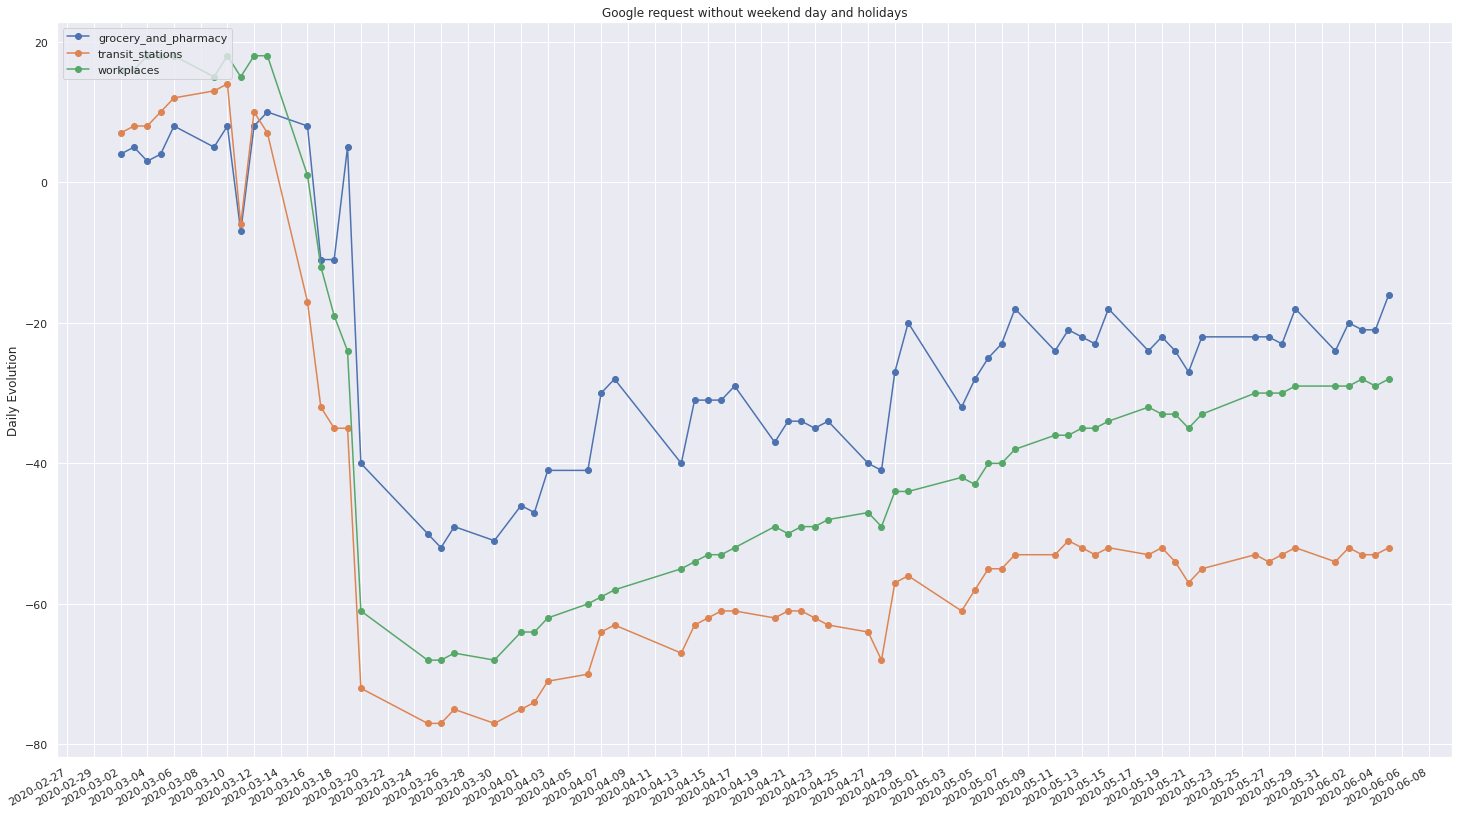

In [65]:
fig, ax = plt.subplots()

ax.plot(df_google_without_weekends_and_holidays['grocery_and_pharmacy_percent_change_from_baseline'], marker='o', linestyle='-', label='grocery_and_pharmacy')
ax.plot(df_google_without_weekends_and_holidays['transit_stations_percent_change_from_baseline'], marker='o', linestyle='-', label='transit_stations')
ax.plot(df_google_without_weekends_and_holidays['workplaces_percent_change_from_baseline'], marker='o', linestyle='-', label='workplaces')

ax.set_ylabel('Daily Evolution')
ax.set_title('Google request without weekend day and holidays')

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

plt.legend(loc="upper left")

fig.autofmt_xdate()

In [0]:
df_only_weekends = get_df_only_weekends(df_google)

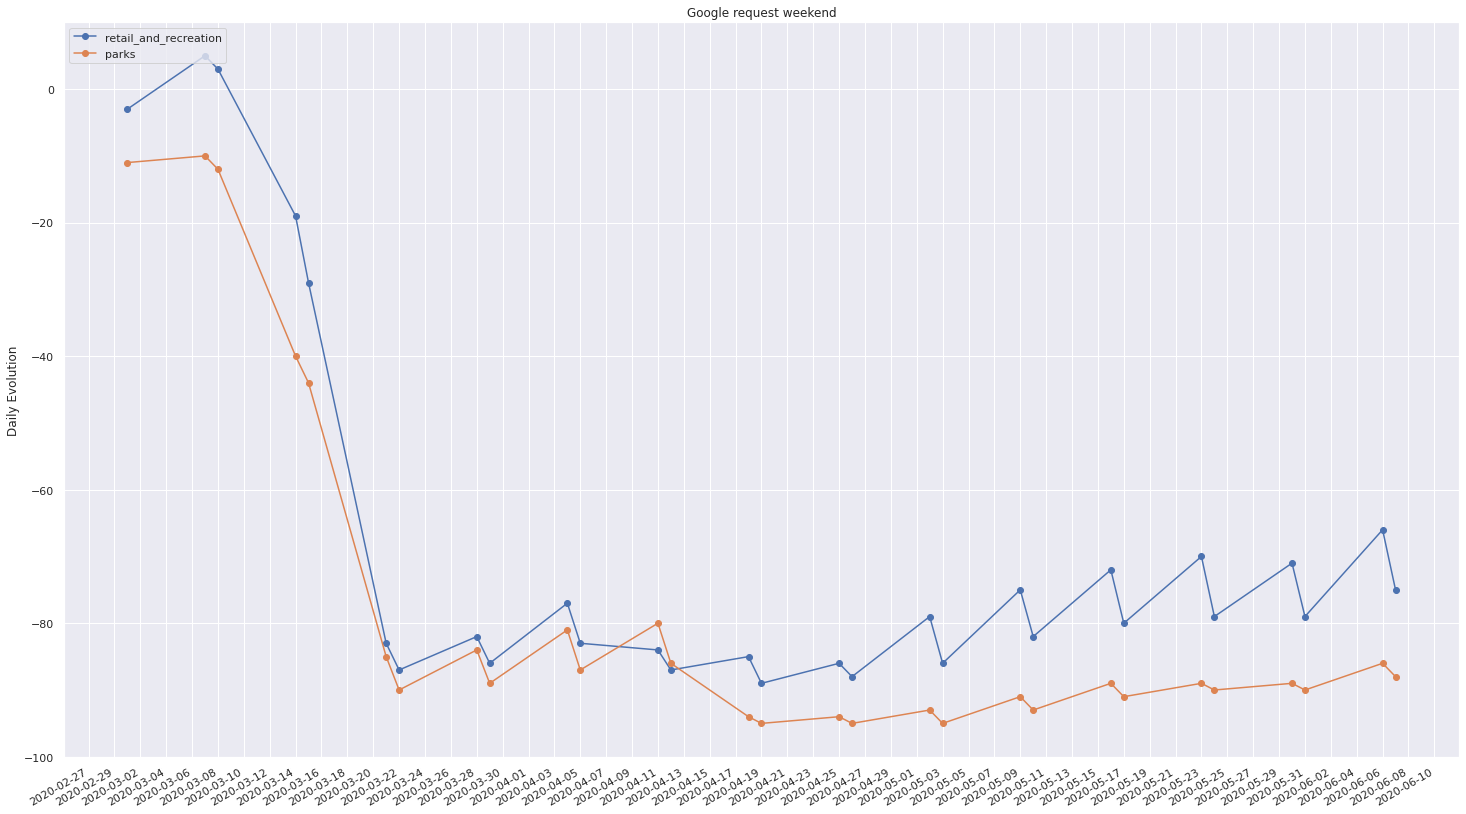

In [67]:
fig, ax = plt.subplots()

ax.plot(df_only_weekends['retail_and_recreation_percent_change_from_baseline'], marker='o', linestyle='-', label='retail_and_recreation')
ax.plot(df_only_weekends['parks_percent_change_from_baseline'], marker='o', linestyle='-', label='parks')
#ax.plot(df_google_only_weekends_and_holidays['residential_percent_change_from_baseline'], marker='o', linestyle='-', label='residential')

ax.set_ylabel('Daily Evolution')
ax.set_title('Google request weekend')

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

plt.legend(loc="upper left")

fig.autofmt_xdate()

# Joins all datasets

In [68]:
df2.index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
               '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08',
               '2020-06-09', '2020-06-10'],
              dtype='datetime64[ns]', name='date', length=102, freq=None)

In [69]:
df_google.index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25',
      

In [70]:
df_apple_argentina_t.index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25',
      

In [0]:
df_all_datasets = pd.concat([df2, df_google, df_apple_argentina_t], axis=1)

In [72]:
df_all_datasets

,confirmed,deaths,recovered,Weekday Name,iso_3166_2_code,census_fips_code,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Weekday Name,driving,walking,driving-100,walking-100,Weekday Name
date,,,,,,,,,,,,,,,,,,
2020-03-01,0,0,0,Sunday,NaN,NaN,-3.0,3.0,-11.0,1.0,-2.0,2.0,Sunday,81.13,68.50,-18.87,-31.50,Sunday
2020-03-02,0,0,0,Monday,NaN,NaN,1.0,4.0,-8.0,7.0,16.0,-1.0,Monday,86.76,101.01,-13.24,1.01,Monday
2020-03-03,1,0,0,Tuesday,NaN,NaN,0.0,5.0,-6.0,8.0,16.0,-1.0,Tuesday,88.90,104.39,-11.10,4.39,Tuesday
2020-03-04,1,0,0,Wednesday,NaN,NaN,-1.0,3.0,-1.0,8.0,18.0,-2.0,Wednesday,92.74,108.23,-7.26,8.23,Wednesday
2020-03-05,1,0,0,Thursday,NaN,NaN,1.0,4.0,-9.0,10.0,18.0,-1.0,Thursday,97.45,113.92,-2.55,13.92,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-06,22020,648,6180,Saturday,NaN,NaN,-66.0,-12.0,-86.0,-50.0,-19.0,18.0,Saturday,47.48,33.53,-52.52,-66.47,Saturday
2020-06-07,22794,664,6909,Sunday,NaN,NaN,-75.0,-33.0,-88.0,-61.0,-22.0,18.0,Sunday,NaN,NaN,NaN,NaN,NaN
2020-06-08,23620,693,7305,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df_all_datasets.to_excel(base_path + 'all_datasets.xlsx')

In [0]:
df_all_datasets.to_csv(base_path + 'all_datasets.csv')